In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import scib
import anndata 

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt


import seaborn as sns

import tissue.api as tissue

import warnings
warnings.filterwarnings("ignore")

import matplotlib 
matplotlib.rcParams.update({'font.size': 10})
plt.rc('axes', labelsize=10)

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [3]:
# user = "david.fischer"
# user = "ina"
user = "mayar.ali"

if user == "david.fischer":
    base_path_gcn = "/Users/david.fischer/phd/seafile/DavidFischer_notforFabian/tissue/grid_searches/basel_zurich/"
    base_path_mi = "/Users/david.fischer/phd/seafile/DavidFischer_notforFabian/tissue/grid_searches/basel_zurich/"
    base_path_reg = "/Users/david.fischer/phd/seafile/DavidFischer_notforFabian/tissue/grid_searches/basel_zurich/"
elif user == "ina":
    base_path_gcn = '../../results/GCN/basel_zurich/'
    base_path_reg = '../../results/REG/basel_zurich/'
    
elif user == "mayar.ali":
    base_path_gcn = "/home/iterm/mayar.ali/phd/projects/tissue/grid_searches/refactor/basel_zurich/"
    base_path_mi = "/home/iterm/mayar.ali/phd/projects/tissue/grid_searches/refactor/basel_zurich/"
    base_path_reg = "/home/iterm/mayar.ali/phd/projects/tissue/grid_searches/refactor/basel_zurich/"


# Overall

In [4]:
dir_figures="/storage/groups/ml01/workspace/mayar.ali/tissue/figures/basel_zurich/"

In [65]:
def get_cells_features(layer_name, interpreter):
    # get features of cells

    if layer_name == 'input':
        h = [interpreter.h[image_key] for image_key in interpreter.img_keys_test]
    else:
        acts = interpreter._get_node_embeddings(
        idx=interpreter.img_keys_test,
        layers=[layer_name]
        )
        h = acts[layer_name]
        
    cells = np.concatenate(h)
    cells = cells[:, cells.std(axis=0) > 0]
    cells = (cells - cells.mean(axis=0)) / cells.std(axis=0)

    images = np.concatenate([[id] * interpreter.h[id].shape[0] for id in interpreter.img_keys_test])

    adata_cells = anndata.AnnData(
        cells,
        obs=pd.DataFrame({
            "images": images,
        })
    )

    adata_cells.obs['images'] = adata_cells.obs['images'].astype('category')
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    adata_cells.obs['images_label'] = le.fit_transform(adata_cells.obs["images"])
    return adata_cells

In [66]:
def get_intergation_metrics(adata_cells, model, cvx):
    
    metrics = [model, cvx]
    from sklearn.linear_model import LogisticRegression
    logreg = LogisticRegression()
    logreg.fit(adata_cells.X, adata_cells.obs["images_label"])

    print(f"{layer_name=}")
    image_score = logreg.score(adata_cells.X, adata_cells.obs["images_label"])
    print(f'Images training score: {image_score}')
    metrics.append(image_score)



    from sklearn.metrics import explained_variance_score, r2_score

    explained_variance_score_images = explained_variance_score(adata_cells.obs["images_label"], 
                                                               logreg.predict(adata_cells.X))
    print(f'Variance explained - images : {explained_variance_score_images}')
    metrics.append(explained_variance_score_images)

    r2_score_images = r2_score(adata_cells.obs["images_label"], 
                               logreg.predict(adata_cells.X), 
                               multioutput='uniform_average')
    print(f'R2 score - images: {r2_score_images}')
    metrics.append(r2_score_images)
    
    n_neighbors=50
    sc.pp.neighbors(adata_cells, n_neighbors=n_neighbors)
    sc.tl.pca(adata_cells)

    label_key="images"
    graph_conn = scib.metrics.graph_connectivity(adata_cells, label_key=label_key)
    metrics.append(graph_conn)
    print(f'graph connectivity metric {layer_name} layer - {label_key} = {graph_conn}')

    label_key="images"
    ilisi = scib.metrics.ilisi_graph(adata_cells, batch_key=label_key)
    metrics.append(ilisi)
    print(f'ilisi graph  metric {layer_name} layer - {label_key} = {ilisi}')

    df = pd.DataFrame(columns=["model", "cv", "prediction_score", "variance_explained", 
                               "r2_score", "graph_connectivity", "ilisi"])
    df.loc[0] = metrics
    return df

#### GCN SS

In [63]:
container_gcnss = tissue.fits.GridSearchContainer(
    source_path={
        "2205191027_GCNSS_NONE_GRADE_STANDARD_basel_zurich_RADIUS_mt_best_model": base_path_gcn,
    },
    gs_ids=[
        "2205191027_GCNSS_NONE_GRADE_STANDARD_basel_zurich_RADIUS_mt_best_model",
        
    ]
)
container_gcnss.load_gs()

loaded 2205191027_GCNSS_NONE_GRADE_STANDARD_basel_zurich_RADIUS_mt_best_model: 1 runs with 3-fold cross validation


In [ ]:
gs_id, model_id, cv = container_gcnss.get_best_model_id(partition_select='val')
container_gcnss.get_info(gs_id = gs_id, model_id=model_id)

In [ ]:
layers = {
    'input': 'input',
    'Layer_gcn_1': 'GCNSS'
}
for cvx in ['cv0', 'cv1', 'cv2']:
    print(cvx)
    interpreter = tissue.fits.InterpreterGraph(results_path=base_path_gcn + gs_id + "/results/", cv=cvx, model_id=model_id, model_class="GCNSS")
    interpreter.load_model()

    data_path="/storage/groups/ml01/workspace/mayar.ali/tissue/data/zenodo/"
    buffered_data_path="/storage/groups/ml01/workspace/mayar.ali/tissue/data/zenodo/buffer/"
    interpreter.get_data_again(
        data_path=data_path,
        buffered_data_path=buffered_data_path,
    )

    for layer_name in ['input', 'Layer_gcn_1']:
        adata_cells = get_cells_features(layer_name=layer_name, interpreter=interpreter)
        df = get_intergation_metrics(adata_cells, layers[layer_name], cvx)
        df_metrics = pd.concat([df_metrics, df], ignore_index=True)

#### GCN

In [70]:
container_gcn = tissue.fits.GridSearchContainer(
    source_path={
        "2205191032_GCN_NONE_GRADE_STANDARD_basel_zurich_RADIUS_best_model": base_path_gcn,
        "2205310906_GCN_NONE_GRADE_STANDARD_basel_zurich_RADIUS_best_model": base_path_gcn,
    },
    gs_ids=[
        "2205191032_GCN_NONE_GRADE_STANDARD_basel_zurich_RADIUS_best_model",
        "2205310906_GCN_NONE_GRADE_STANDARD_basel_zurich_RADIUS_best_model"
        
    ]
)
container_gcn.load_gs()

loaded 2205191032_GCN_NONE_GRADE_STANDARD_basel_zurich_RADIUS_best_model: 1 runs with 3-fold cross validation
loaded 2205310906_GCN_NONE_GRADE_STANDARD_basel_zurich_RADIUS_best_model: 1 runs with 3-fold cross validation


In [ ]:
gs_id, model_id, cv = container_gcn.get_best_model_id(partition_select='val')
container_gcn.get_info(gs_id = gs_id, model_id=model_id)

In [ ]:
for cvx in ['cv0', 'cv1', 'cv2']:
    interpreter = tissue.fits.InterpreterGraph(results_path=base_path_gcn + gs_id + "/results/", cv=cvx, model_id=model_id, model_class="GCN")
    interpreter.load_model()
    data_path="/storage/groups/ml01/workspace/mayar.ali/tissue/data/zenodo/"
    buffered_data_path="/storage/groups/ml01/workspace/mayar.ali/tissue/data/zenodo/buffer/"
    interpreter.get_data_again(
        data_path=data_path,
        buffered_data_path=buffered_data_path,
    )

    layer_name='Layer_gcn_1'
    adata_cells = get_cells_features(layer_name=layer_name, interpreter=interpreter)
    df = get_intergation_metrics(adata_cells, "GCN", cvx)
    df_metrics = pd.concat([df_metrics, df], ignore_index=True)

#### MI

In [73]:
container_mi = tissue.fits.GridSearchContainer(
    source_path={
        "2205191134_MI_NONE_GRADE_STANDARD_basel_zurich_RADIUS_best_model": base_path_gcn,
    },
    gs_ids=[
        "2205191134_MI_NONE_GRADE_STANDARD_basel_zurich_RADIUS_best_model",
        
    ]
)
container_mi.load_gs()

loaded 2205191134_MI_NONE_GRADE_STANDARD_basel_zurich_RADIUS_best_model: 1 runs with 3-fold cross validation


In [ ]:
gs_id, model_id, cv = container_mi.get_best_model_id(partition_select='val')
container_mi.get_info(gs_id = gs_id, model_id=model_id)

In [ ]:
for cvx in ['cv0', 'cv1', 'cv2']:
    interpreter = tissue.fits.InterpreterNoGraph(results_path=base_path_gcn + gs_id + "/results/", cv=cv, model_id=model_id, model_class="MI")
    interpreter.load_model()
    data_path="/storage/groups/ml01/workspace/mayar.ali/tissue/data/zenodo/"
    buffered_data_path="/storage/groups/ml01/workspace/mayar.ali/tissue/data/zenodo/buffer/"
    interpreter.get_data_again(
        data_path=data_path,
        buffered_data_path=buffered_data_path,
    )

    layer_name='Layer_dense_feature_embedding0'
    adata_cells = get_cells_features(layer_name=layer_name, interpreter=interpreter)
    df = get_intergation_metrics(adata_cells, "MI", cvx)
    df_metrics = pd.concat([df_metrics, df], ignore_index=True)

#### Plot integration metrics

<Figure size 720x720 with 0 Axes>

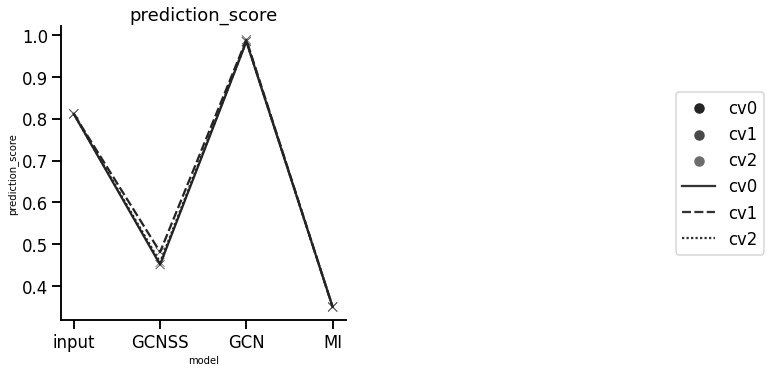

<Figure size 720x720 with 0 Axes>

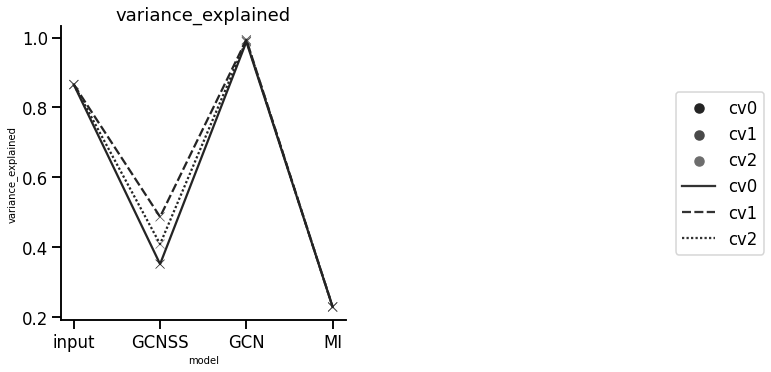

<Figure size 720x720 with 0 Axes>

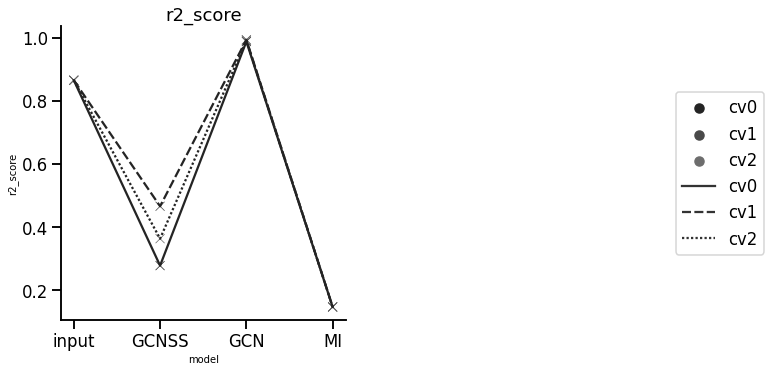

<Figure size 720x720 with 0 Axes>

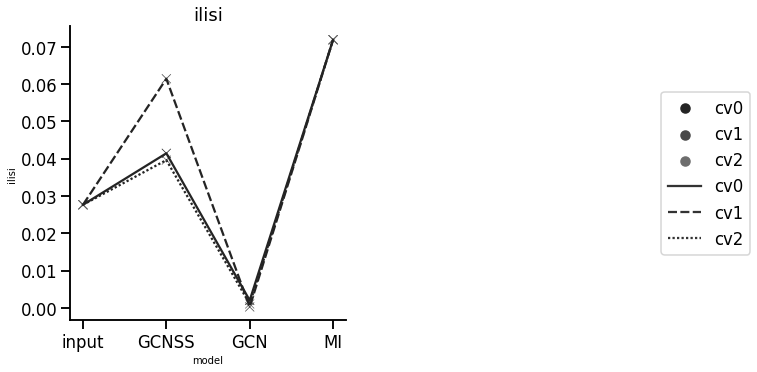

<Figure size 720x720 with 0 Axes>

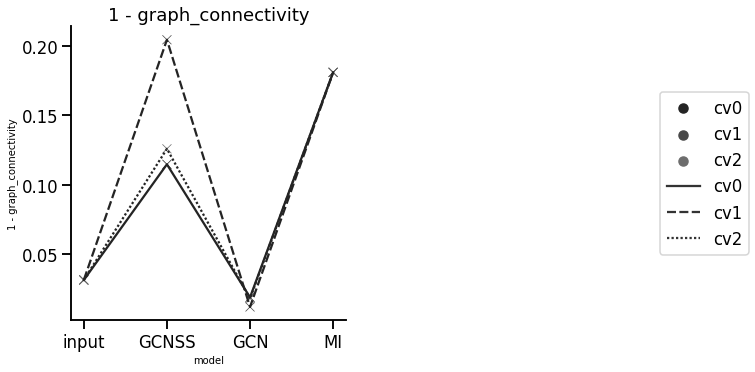

In [80]:
sns.set_palette('gray')

for i, metric in enumerate(["prediction_score","variance_explained","r2_score","ilisi","1 - graph_connectivity"]):
    plt.figure(figsize=(10,10))
    g = sns.FacetGrid(df_metrics, size=5)
    g.map(sns.scatterplot, "model", metric, hue=df_metrics["cv"], marker='x')
    g.map(sns.lineplot, "model", metric, style=df_metrics["cv"], linestyle='--')
    plt.legend(bbox_to_anchor=[2.5, 0.5], loc="right")
    plt.title(metric)
    plt.tight_layout()
    plt.savefig(dir_figures + f"{metric}_cvs.pdf", bbox_inches = "tight")

    plt.show()


In [82]:
df_metrics_mean = pd.DataFrame(columns=["prediction_score", "variance_explained", "r2_score", "graph_connectivity", "ilisi", "1 - graph_connectivity"])
for model in ["input", "GCNSS", "GCN", "MI"]:
    df_metrics_mean.loc[model] = df_metrics[df_metrics["model"] == model].mean().values
df_metrics_mean.to_csv(dir_figures + "df_metrics_mean.csv")